<a href="https://colab.research.google.com/github/Shubhkj/Lunar-Lander/blob/main/Advantage_Actor_Crtic(A2C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.0 MB/s eta 0:00:00


In [ ]:
pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.7 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376100 sha256=13711efa780c1e712e0624d40081a7d7ae91bcd4a3f1e986775a924260830507
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym

In [ ]:
train_env = gym.make('LunarLander-v2')
test_env = gym.make('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.1):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()

        self.actor = actor
        self.critic = critic

    def forward(self, state):

        action_pred = self.actor(state)
        value_pred = self.critic(state)

        return action_pred, value_pred

In [ ]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = test_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [ ]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [ ]:
LEARNING_RATE = 0.0005

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [ ]:
def train(env, policy, optimizer, discount_factor):

    policy.train()

    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        action_pred = actor(state)
        value_pred = critic(state)

        action_prob = F.softmax(action_pred, dim = -1)

        dist = distributions.Categorical(action_prob)

        action = dist.sample()

        log_prob_action = dist.log_prob(action)

        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)

    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)

    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, optimizer)

    return policy_loss, value_loss, episode_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def calculate_returns(rewards, discount_factor, normalize = True):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:

        returns = (returns - returns.mean()) / returns.std()

    return returns

In [ ]:
def calculate_advantages(returns, values, normalize = True):

    advantages = returns - values

    if normalize:

        advantages = (advantages - advantages.mean()) / advantages.std()

    return advantages

In [ ]:
def update_policy(advantages, log_prob_actions, returns, values, optimizer):

    advantages = advantages.detach()
    returns = returns.detach()

    policy_loss = - (advantages * log_prob_actions).sum()

    value_loss = F.smooth_l1_loss(returns, values).sum()

    optimizer.zero_grad()

    policy_loss.backward()
    value_loss.backward()

    optimizer.step()

    return policy_loss.item(), value_loss.item()

In [ ]:
def evaluate(env, policy):

    policy.eval()

    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():

            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)

        action = torch.argmax(action_prob, dim = -1)

        state, reward, done, _ = env.step(action.item())

        episode_reward += reward

    return episode_reward

In [ ]:
MAX_EPISODES = 2000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 10

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):

    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR)

    test_reward = evaluate(test_env, policy)

    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])

    if episode % PRINT_EVERY == 0:

        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |')

    if mean_test_rewards >= REWARD_THRESHOLD:

        print(f'Reached reward threshold in {episode} episodes')

        break

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| Episode:  10 | Mean Train Rewards:  -194.9 | Mean Test Rewards:  -159.2 |
| Episode:  20 | Mean Train Rewards:  -170.6 | Mean Test Rewards:  -178.8 |
| Episode:  30 | Mean Train Rewards:  -157.7 | Mean Test Rewards:  -178.0 |
| Episode:  40 | Mean Train Rewards:  -154.8 | Mean Test Rewards:  -175.3 |
| Episode:  50 | Mean Train Rewards:  -140.3 | Mean Test Rewards:  -174.0 |
| Episode:  60 | Mean Train Rewards:  -129.7 | Mean Test Rewards:  -290.1 |
| Episode:  70 | Mean Train Rewards:  -118.6 | Mean Test Rewards:  -605.3 |
| Episode:  80 | Mean Train Rewards:  -126.4 | Mean Test Rewards:  -835.8 |
| Episode:  90 | Mean Train Rewards:  -145.9 | Mean Test Rewards: -1048.7 |
| Episode: 100 | Mean Train Rewards:  -158.3 | Mean Test Rewards: -1172.4 |
| Episode: 110 | Mean Train Rewards:  -131.4 | Mean Test Rewards:  -956.5 |
| Episode: 120 | Mean Train Rewards:  -137.5 | Mean Test Rewards:  -752.0 |
| Episode: 130 | Mean Train Rewards:  -172.0 | Mean Test Rewards:  -749.5 |
| Episode: 1

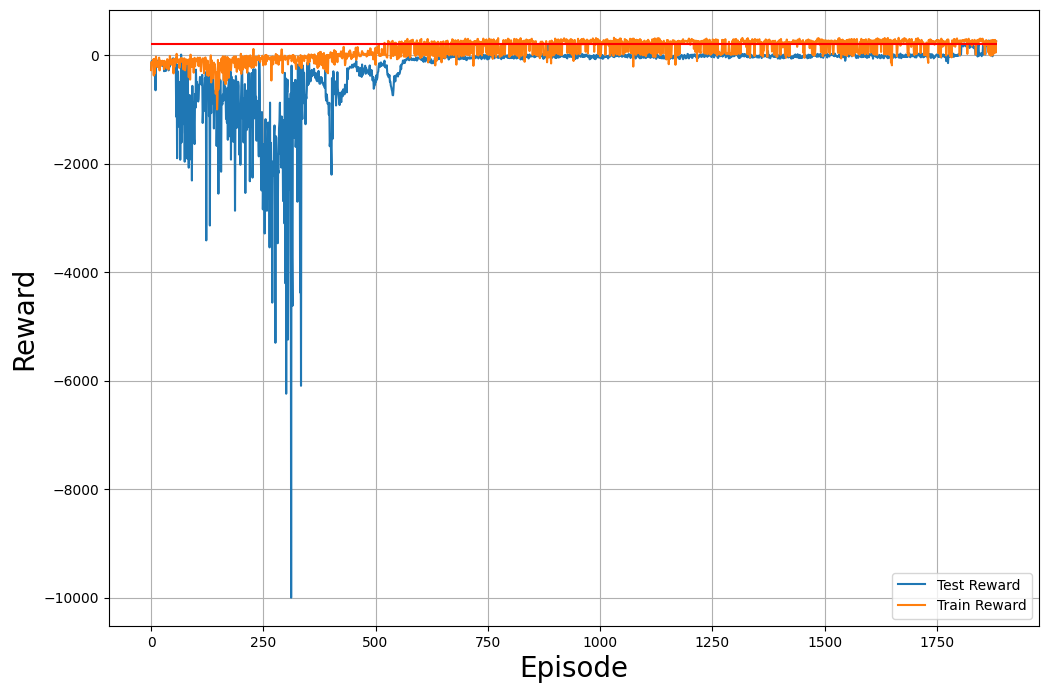

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()